<a href="https://colab.research.google.com/github/narenq7/Dive2DLPytorch/blob/main/Actor_Critic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Actor-Critic Algorithm [RL an Introduction by R. S. Sutton and A. G. Barto]

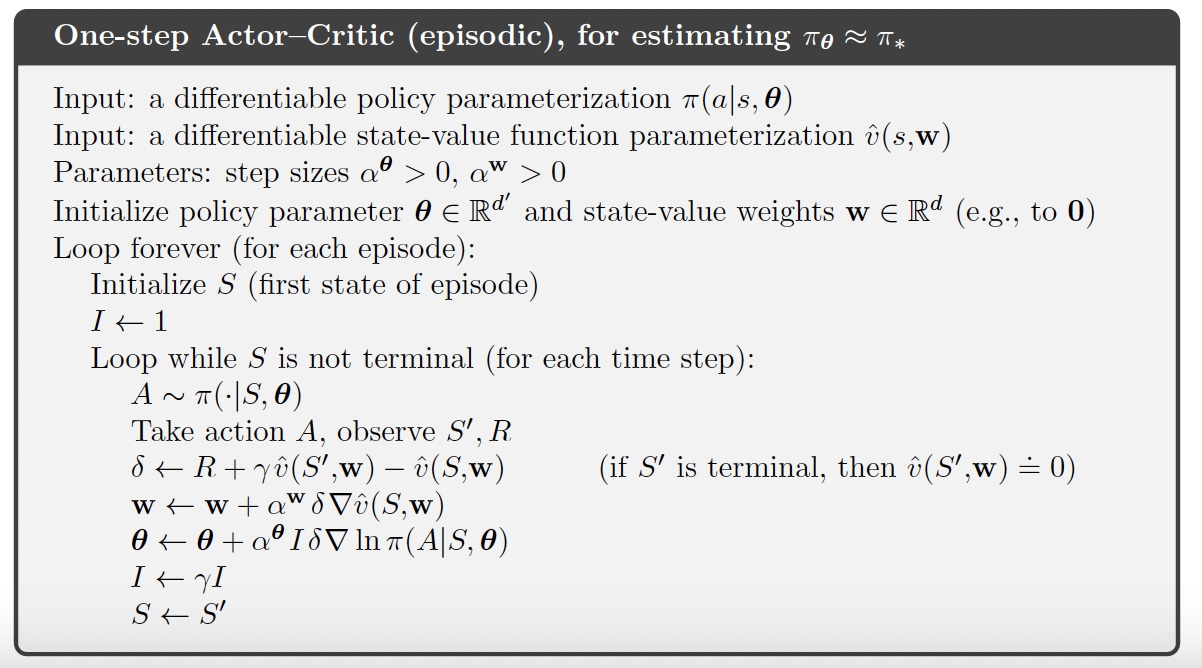

Install required packages

In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.3 MB/s eta 0:00:00


Display plot and video

In [ ]:
from IPython.display import display, clear_output, HTML
import imageio
import base64
import matplotlib.pyplot as plt
import time

def live_plot(fig, ax, line, x, y, x_name='x', y_name='y', title_name='Data'):
    line.set_data(x, y)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(f'{x_name} vs {y_name} for {title_name}')

    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True) # Clear output before displaying the updated plot
    display(fig)            # Display the updated plot

def display_frames_as_gif(frames):
    """Displays a list of frames as a gif"""

    # Encode frames to video
    with imageio.get_writer('animation.mp4', mode='I', fps=60) as writer:
        for frame in frames:
            writer.append_data(frame)

    # Read video and encode to base64
    with open('animation.mp4', 'rb') as f:
        video_data = f.read()
    video_data_base64 = base64.b64encode(video_data).decode('utf-8')

    # Create HTML video element
    html = f"""
    <video width="400" height="300" controls>
        <source src="data:video/mp4;base64,{video_data_base64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display the video in the notebook
    clear_output(wait=True)
    display(HTML(html))

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Hyperparameters
LEARNING_RATE_A = 0.0001
LEARNING_RATE_C = 0.0005
GAMMA = 0.99
EPISODES = 1000

# Actor-Critic Networks
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)  # Softmax for probabilities
        return x

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Loop
def train():
    env_name='LunarLander-v2'
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)

    actor_optimizer = optim.Adam(actor.parameters(), lr=LEARNING_RATE_A)
    critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE_C)

    episode_lists = [0.,]
    reward_lists = [0.,]
    fig, ax = plt.subplots()
    line, = ax.plot(episode_lists, reward_lists)

    for episode in range(EPISODES):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0
        done = False

        while not done:
            # Select action
            probs = actor(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.tensor(next_state, dtype=torch.float32)
            total_reward += reward

            # Compute advantage
            value = critic(state)
            next_value = critic(next_state) if not done else 0
            advantage = reward + GAMMA * next_value - value

            # Update actor
            actor_loss = -dist.log_prob(action) * advantage.detach() # Gradient ascent #Frameworks like PyTorch, default to gradient descent, so - sign is present
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Update critic
            critic_loss = advantage.pow(2)
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            state = next_state

        print(f"Episode {episode}, Total Reward: {total_reward}")

        episode_lists.append(episode)
        reward_lists.append(total_reward)

        if episode % 50 == 0:
            live_plot(fig, ax, line, episode_lists, reward_lists, 'Episode', 'Episode Reward', f'PG in {env_name}')

    with torch.inference_mode():
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        frames = []
        for _ in range(1000):
            probs = actor(state)
            action = torch.argmax(probs).item()
            next_state, reward, done, _ = env.step(action)
            frame = env.render(mode='rgb_array')
            state = torch.tensor(next_state, dtype=torch.float32)

            if done:
                state = env.reset()
                state = torch.tensor(next_state, dtype=torch.float32)

            frames.append(frame)

    env.close()
    return frames

frames = train()


Task 1: Run the code

Task 2: Try different values of EPISODES and check total reward.

Task 3: Try different values of parameters such as LEARNING_RATE_A and LEARNING_RATE_C and check total reward.


Display Learned Agent

In [ ]:
display_frames_as_gif(frames)